# Lab 08: SVMs Part II

In this lab, we will experiment with soft-margin linear and nonlinear SVMs as well as efficient optimization of SVMs.

## Soft Margin SVMs

We saw in class that to handle non-separable data, we make the margin soft, allowing examples to intrude on it. To minimize the extent to which
this happens, we introduce a \textit{slack variable} $\xi_i$ for each example $i$ that expresses how far example $i$ intrudes into the soft margin
region. $xi_i = 0$ means example $i$ is correctly classified and does not intrude on the margin region. $0 < \xi_i < 1$ means that example $i$ is
inside the margin but on the $y^{(i)}$ side of the separating hyperplane. $xi_i = 1$ means $\mathbf{x}^{(i)}$ is on the separating hyperplane.
$\xi_i > 1$ means $\mathbf{x}^{(i)}$ is incorrectly classified. This idea gives us the following optimization problem:
$$
\begin{array}{rl}
\min_{\mathbf{w},b,\mathbf{\xi}} & \frac{1}{2}\|\mathbf{w}\|^2 + C\sum_{i=1}^m \xi_i \\
\text{such that}                 & y^{(i)}(\mathbf{w}^\top \mathbf{x}^{(i)}+b) \ge 1-\xi_i, i \in 1..m \\
                                 & \xi_i \ge 0, i \in 1..m
\end{array}
$$

$C$ is a hyperparameter controlling the tradeoff between minimizing $\|\mathbf{w}\|$ and minimizing the $\xi_i$'s. $C$ should be determined through
a search procedure using an independent validation set.

When we write the new Lagrangian, including new Lagrange multipliers $r_i$ for the constraints $\xi_i \ge 0$, differentiate with respect to $\mathbf{w}$ and
$b$, substitute the optimal $\mathbf{w}$ and $b$ into the dual objective function, and impose the KKT constraints, we obtain the new optimization problem
$$
\begin{array}{rl}
\max_{\mathbf{\alpha}} & W(\mathbf{\alpha}) = \sum_{i=1}^m\alpha_i - \frac{1}{2}\sum_{i,j=1}^m y^{(i)}y^{(j)}\alpha_i\alpha_j
                                                                                               \left< \mathbf{x}^{(i)},\mathbf{x}^{(j)} \right> \\
\text{such that}       & 0 \le \alpha_i \le C, i \in 1..m \\
                       & \sum_{i=1}^m \alpha_i y^{(i)} = 0 ,
\end{array}
$$

where we can replace the linear kernel $\left< \mathbf{x}^{(i)},\mathbf{x}^{(j)} \right>$ with any valid kernel $K(\mathbf{x}^{(i)},\mathbf{x}^{(j)})$.
We can now interpret the values of $\alpha_i$ in relation to $C$ as follows:
$$
\begin{eqnarray}
\alpha_i = 0     & \implies & y^{(i)}(\mathbf{w}^\top \mathbf{x}^{(i)}+b) \ge 1 \nonumber \\
\alpha_i = C     & \implies & y^{(i)}(\mathbf{w}^\top \mathbf{x}^{(i)}+b) \le 1 \nonumber \\
0 < \alpha_i < C & \implies & y^{(i)}(\mathbf{w}^\top \mathbf{x}^{(i)}+b) = 1 \nonumber
\end{eqnarray}
$$

## Exercise 1

Consider a dataset in which examples from two classes are sampled from overlapping spherical 2D Gaussians. The code below generates
200 samples from each of two classes with
$\mu_1 = \begin{bmatrix} 3 \\ 3 \end{bmatrix}$, $\Sigma_1 = \begin{bmatrix} 4 & 0 \\ 0 & 4 \end{bmatrix}$,
$\mu_2 = \begin{bmatrix} 5 \\ 5 \end{bmatrix}$, and $\Sigma_2 = \begin{bmatrix} 4 & 0 \\ 0 & 4 \end{bmatrix}$.

(320, 2) (320, 1)
(80, 2) (80, 1)


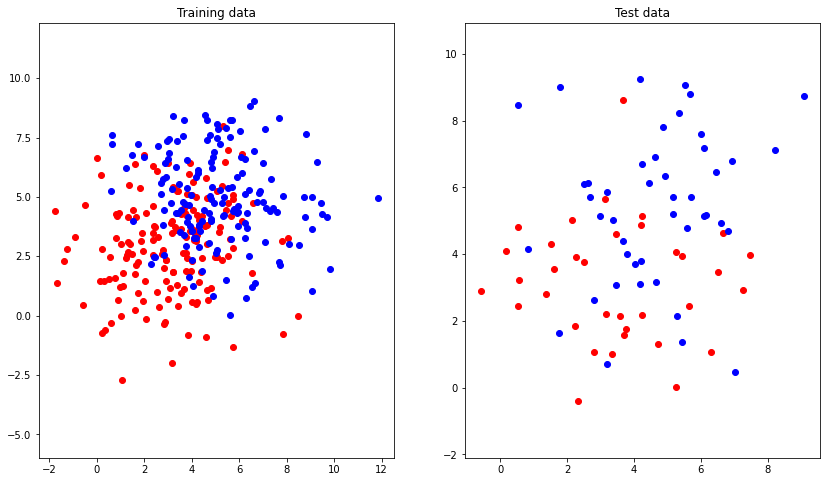

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(mu1, Sigma1, mu2, Sigma2):
    X1 = np.random.multivariate_normal(mu1, Sigma, 200)
    y1 = -np.ones((200,1))
    X2 = np.random.multivariate_normal(mu2, Sigma, 200)
    y2 = np.ones((200,1))
    X = np.concatenate((X1, X2), 0)
    y = np.concatenate((y1, y2), 0)
    idx = np.arange(0, 400)
    np.random.shuffle(idx)
    train_idx = idx[0:320]
    test_idx = idx[320:]
    X_train = X[train_idx,:]
    X_test = X[test_idx,:]
    y_train = y[train_idx,:]
    y_test = y[test_idx,:]
    return X_train, X_test, y_train, y_test

mu1 = [3, 3]
Sigma = [[4, 0], [0, 4]]
mu2 = [5, 5]
X_train, X_test, y_train, y_test = generate_data(mu1, Sigma, mu2, Sigma)

def plot_data(X, y, title):
    X_0 = X[(y==-1).flat]
    X_1 = X[(y==1).flat]
    plt.plot(X_0[:,0], X_0[:,1], 'ro')
    plt.plot(X_1[:,0], X_1[:,1], 'bo')
    plt.title(title)
    plt.axis('equal')
    
plt.rcParams["figure.figsize"] = (14, 8)
plt.subplot(1, 2, 1)
plot_data(X_train, y_train, 'Training data')
plt.subplot(1, 2, 2)
plot_data(X_test, y_test, 'Test data')
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
# print(type(X_test))

Let's build a soft-margin linear SVM for this dataset. Recall the QP setting.
A QP problem aims to find $\textbf{x}$ satisfying
$$
\begin{array}{rl}
\text{min}_{\textbf{x}} & \frac{1}{2}\textbf{x}^\top \texttt{Q} \textbf{x} + \textbf{c}^\top\textbf{x} \\
\text{subject to}       & \texttt{A}\textbf{x} \le \textbf{b} \\
                        & \texttt{E}\textbf{x} = \textbf{d} .
\end{array}
$$

First, we need our wrapper for cvxopt:

In [3]:
import cvxopt

def cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None):
    Q = .5 * (Q + Q.T)  # make sure Q is symmetric
    args = [cvxopt.matrix(Q), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((Q.shape[1],))

Next we set up the QP problem. Verify that the dual soft margin optimization above can be written as the QP problem

$$
\begin{array}{rcl}
\mathtt{Q} & = & \text{diag}(\mathbf{y}) \; \mathtt{K} \; \text{diag}(\mathbf{y}) \\
\mathbf{c} & = & \begin{bmatrix} -1 \\ -1 \\ \vdots \end{bmatrix} \\
\mathtt{A} & = & \begin{bmatrix} -\mathtt{I}_{m\times m} \\ \mathtt{I}_{m\times m} \end{bmatrix} \\
\mathbf{b} & = & \begin{bmatrix} 0 \\ \vdots \\ 0 \\ C \\ \vdots \\ C \end{bmatrix} \\
\mathtt{E} & = & \mathbf{y}^\top \\
\mathbf{d} & = & \begin{bmatrix} 0 \end{bmatrix}.
\end{array}
$$


In [4]:
C = 1000.1

m = X_train.shape[0];
n = X_train.shape[1];

def linear_kernel(X):
    m = X.shape[0];
    K = np.matrix(np.zeros([m,m]));
    for i in range(0,m):
        for j in range(0,m):
            K[i,j] = X[i,:] @ X[j,:].T
    return K;

K = linear_kernel(X_train);

Q = np.multiply(y_train * y_train.T, K)
print('Q rank: %d' % np.linalg.matrix_rank(Q))
c = -np.ones([m]);
A = np.concatenate([-np.eye(m), np.eye(m)], 0);
b = np.concatenate([np.zeros([m]), C*np.ones([m])], 0);
E = y_train.T;
d = np.zeros(1);
alpha_star = cvxopt_solve_qp(Q, c, A, b, E, d);

# print(alpha_star)

Q rank: 2


Let's get $\mathbf{w}$ and $b$ and plot:

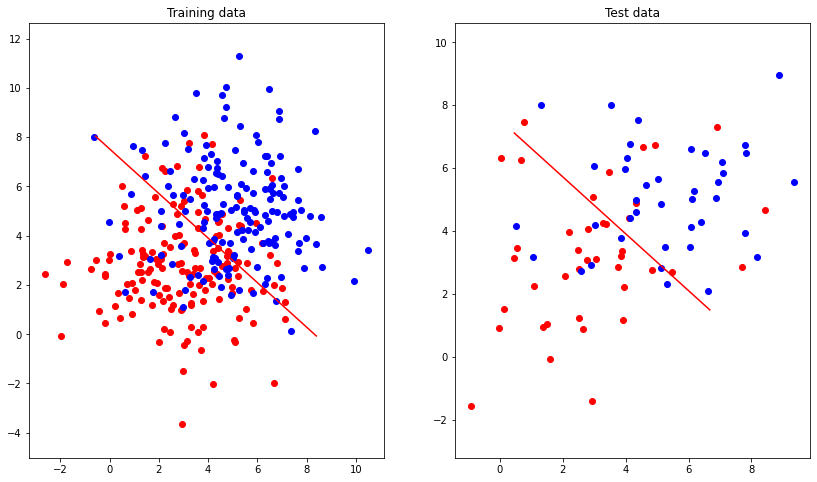

In [5]:
def get_wb(X, y, alpha):
    n = X.shape[1]
    # Find the support vectors
    S = alpha > 1e-6
    XS = X[S,:]
    yS = y[S]
    alphaS = alpha[S]
    alphaSyS = np.tile(np.multiply(yS.T, alphaS).T, n)
    w = sum(np.multiply(alphaSyS, XS)).T
    # Find b
    KS = K[S,:][:,S]
    NS = yS.shape[0]
    b = (np.sum(yS) - np.sum(np.multiply(alphaS,yS.T)*KS))/NS
    # Normalize w,b
    scalef = np.linalg.norm(w)
    w = w / scalef
    b = b / scalef
    return w,b

w,b = get_wb(X_train, y_train, alpha_star)

def boundary_points(X, w, b):
    v_orthogonal = np.array([[w[0]],[w[1]]])
    v_ortho_length = np.sqrt(v_orthogonal.T @ v_orthogonal)
    dist_ortho = b / v_ortho_length
    v_orthogonal = v_orthogonal / v_ortho_length
    v_parallel = np.array([[-v_orthogonal[1,0]],[v_orthogonal[0,0]]])
    projections = X @ v_parallel
    proj_1 = min(projections)
    proj_2 = max(projections)
    point_1 = proj_1 * v_parallel - dist_ortho * v_orthogonal
    point_2 = proj_2 * v_parallel - dist_ortho * v_orthogonal
    return point_1, point_2

def plot_w(X, w, b):
    p1, p2 = boundary_points(X, w, b)
    plt.plot((p1[0],p2[0]), (p1[1],p2[1]), 'r-')

plt.rcParams["figure.figsize"] = (14, 8)
plt.subplot(1, 2, 1)
plot_data(X_train, y_train, 'Training data')
plot_w(X_train, w, b)
plt.subplot(1, 2, 2)
plot_data(X_test, y_test, 'Test data')
plot_w(X_test, w, b)


## To do in lab

Do the following:
1. Implement a function to evaluate the accuracy of your SVM on the test set
2. Implement a search procedure to find the best value of $C$.
Report your findings in the lab report.

In [5]:
y_pred = np.sign((X_test@ w)+b)
y_test = y_test.ravel()

print(f"Accuracy = {sum(y_pred == y_test)/y_test.shape[0]}")

Accuracy = 0.8625


2. Implement a search procedure to find the best value of $C$.

In [6]:
power_k = np.arange(-18,10,dtype=float)
print(power_k)
m = X_train.shape[0];
n = X_train.shape[1];
K = linear_kernel(X_train);
Q = np.multiply(y_train * y_train.T, K)
print('Q rank: %d' % np.linalg.matrix_rank(Q))
c = -np.ones([m]);
A = np.concatenate([-np.eye(m), np.eye(m)], 0);
E = y_train.T;
d = np.zeros(1);
acc_list = []
C_list = []
for ke in power_k:
    C = pow(2, ke)
    print("=============================================")
    b = np.concatenate([np.zeros([m]), C*np.ones([m])], 0);
    alpha_star = cvxopt_solve_qp(Q, c, A, b, E, d);
    w,b = get_wb(X_train, y_train, alpha_star)
    y_pred = np.sign((X_test @ w) + b)
    print(f"At C = {C} | Accuracy = {sum(y_pred == y_test)/ y_test.shape[0]}")
    acc_list.append(sum(y_pred == y_test)/ y_test.shape[0])
    C_list.append(C)

[-18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.
  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.]
Q rank: 2
At C = 3.814697265625e-06 | Accuracy = 0.6375
At C = 7.62939453125e-06 | Accuracy = 0.8625
At C = 1.52587890625e-05 | Accuracy = 0.8625
At C = 3.0517578125e-05 | Accuracy = 0.8625
At C = 6.103515625e-05 | Accuracy = 0.8625
At C = 0.0001220703125 | Accuracy = 0.8625
At C = 0.000244140625 | Accuracy = 0.8625
At C = 0.00048828125 | Accuracy = 0.8625
At C = 0.0009765625 | Accuracy = 0.8625
At C = 0.001953125 | Accuracy = 0.8625
At C = 0.00390625 | Accuracy = 0.8625
At C = 0.0078125 | Accuracy = 0.85
At C = 0.015625 | Accuracy = 0.8625
At C = 0.03125 | Accuracy = 0.8375
At C = 0.0625 | Accuracy = 0.8375
At C = 0.125 | Accuracy = 0.8625
At C = 0.25 | Accuracy = 0.8625
At C = 0.5 | Accuracy = 0.85
At C = 1.0 | Accuracy = 0.8625
At C = 2.0 | Accuracy = 0.8625
At C = 4.0 | Accuracy = 0.85
At C = 8.0 | Accuracy = 0.8625
At C = 16.0 | Accuracy = 

[0.6375, 0.8625, 0.8625, 0.8625, 0.8625, 0.8625, 0.8625, 0.8625, 0.8625, 0.8625, 0.8625, 0.85, 0.8625, 0.8375, 0.8375, 0.8625, 0.8625, 0.85, 0.8625, 0.8625, 0.85, 0.8625, 0.8625, 0.85, 0.8625, 0.8625, 0.8625, 0.8625]


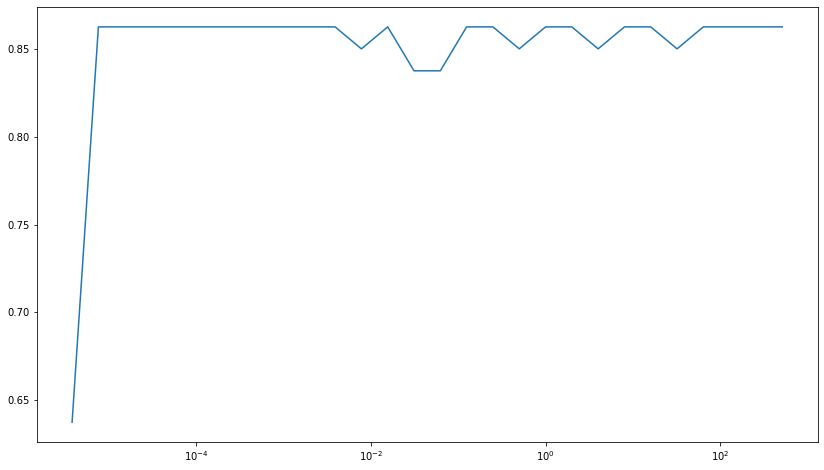

In [7]:
plt.plot(C_list,acc_list)
plt.xscale('log')
print(acc_list)

## Take home exercise

Remember the 2D annulus problem with overlap? Get the code above working on that example. You'll need to use the
Gaussian kernel rather than the linear kernel. Report your findings in the lab report. Your hyperparameter search
should be over both $C$ and $\sigma$ ($\gamma$ in some descriptions of the Gaussian/RBF kernel).

In [8]:
# Generate data for class 1

mu_1 = np.array([1.0, 2.0])
sigma_1 = 0.5
num_sample = 100
cov_mat = np.matrix([[sigma_1,0],[0,sigma_1]])
# print(cov_mat)
X1 = np.random.multivariate_normal(mean= mu_1, cov=cov_mat, size = num_sample)

# Generate data for class 2

angle = np.random.uniform(0, 2*np.pi, num_sample)
d =  np.random.normal(np.square(3*sigma_1),np.square(.5*sigma_1),num_sample)

X2 = np.array([X1[:,0] + d*np.cos(angle), X1[:,1] + d*np.sin(angle)]).T

# Combine X1 and X2 into single dataset

# print(X1.shape,X2.shape)
X = np.concatenate([X1, X2],axis = 0)
y = np.append(np.zeros(num_sample),np.ones(num_sample))
# y = y.reshape(-1,1)
# print(X.shape,y.shape)
# print(X[:10,:])
# print(y)

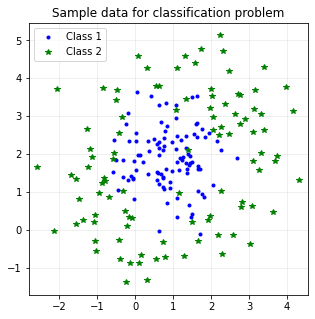

In [9]:
# Plot the data
fig1 = plt.figure(figsize=(5,5))
ax = plt.axes() 
plt.title('Sample data for classification problem')
plt.grid(axis='both', alpha=.25)
plt.plot(X1[:,0],X1[:,1],'b.', label = 'Class 1')
plt.plot(X2[:,0],X2[:,1],'g*', label = 'Class 2')
plt.legend(loc=2)
plt.axis('equal')
plt.show()

In [19]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,shuffle = True)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(140, 2)
(60, 2)
(140, 1)
(60, 1)


In [20]:
# C = 1000.1

m = X_train.shape[0];
n = X_train.shape[1];

def gauss_kernel(X):
    sigma = 0.2
    m = X.shape[0];
    K = np.matrix(np.zeros([m,m]));
    for i in range(0,m):
        for j in range(0,m):
            K[i,j] = (X[i,:] - X[j,:]) * (X[i,:] - X[j,:]).T
    K = np.exp(-K/(2*sigma*sigma))      
    return K;

In [21]:
power_k = np.arange(-18,10,dtype=float)
print(power_k)
m = X_train.shape[0];
n = X_train.shape[1];
K = gauss_kernel(X_train);
Q = np.multiply(y_train * y_train.T, K)
print('Q rank: %d' % np.linalg.matrix_rank(Q))
c = -np.ones([m]);
A = np.concatenate([-np.eye(m), np.eye(m)], 0);
E = y_train.T;
d = np.zeros(1);
acc_list = []
C_list = []
for ke in power_k:
    C = pow(2, ke)
    print("=============================================")
    b = np.concatenate([np.zeros([m]), C*np.ones([m])], 0);
    alpha_star = cvxopt_solve_qp(Q, c, A, b, E, d);
    w,b = get_wb(X_train, y_train, alpha_star)
    y_pred = np.sign((X_test @ w) + b)
    print(f"At C = {C} | Accuracy = {sum(y_pred == y_test)/ y_test.shape[0]}")
    acc_list.append(sum(y_pred == y_test)/ y_test.shape[0])
    C_list.append(C)

[-18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.
  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.]


ValueError: setting an array element with a sequence.


## Exercise 2: SMO optimization

As we have learned, the QP solution to the SVM is not practical for large datasets.

Next, we'll get the general idea of the SMO algorithm used to optimize large SVMs in practice. The idea is similar to
coordinate ascent except that we cannot manipulate $\alpha_i$'s independently due to the KKT constraints required for
equivalence of the primal and dual form of the constrained optimization problem.

This example has been adapted from
[An Introduction to Support Vector Machine (SVM) and the Simplified SMO Algorithm](https://www.codeproject.com/Articles/1267445/An-Introduction-to-Support-Vector-Machine-SVM-and) by "Coding Notes."

We begin with all $\alpha_i=0$.
We repeatedly iterate over all $\alpha_i$, $i \in 1..m$. If $\alpha_i$ does not fulfill the KKT conditions, then we
must consider optimizing $\alpha_i$ in concert with some other $\alpha_j$. The KKT conditions imply that if $\alpha_i = 0$, then
it must be the case that $y^{(i)} h(\mathbf{x}^{(i)}) > 1$, and if $0 < \alpha_i < C$, it must be the case that $y^{(i)} h(\mathbf{x}^{(i)}) = 1$.

If either of these constraints are violated, we
select an $\alpha_j$ at random from the remaining $(m − 1)$ $\alpha$ variables and then jointly optimize $\alpha_i$ and $\alpha_j$,
holding all other $\alpha_k$ fixed.

If the vector $\mathbf{\alpha}$ does not change after some number of passes, then the algorithm terminates.

To optimize the pair $(\alpha_i,\alpha_j)$, we do the following:
 - $E_i \leftarrow h(\mathbf{x}^{(i)}) - y^{(i)}$
 - $E_j \leftarrow h(\mathbf{x}^{(j)}) - y^{(j)}$
 - $\alpha_j^{(old)} \leftarrow \alpha_j$
 - $\alpha_j' \leftarrow \alpha_j^{(old)} - \frac{y^{(j)}(E_i - E_j)}{\eta}$ 
 - $\eta = 2 \langle x^{(i)}, x^{(j)} \rangle - \langle x^{(i)} , x^{(i)} \rangle - \langle x^{(j)}, x^{(j)} \rangle$
 - $L = \begin{cases} \max(0, \alpha_i + \alpha_j − C)  & \text{if} \; y^{(i)} = y^{(j)} \\
                      \max(0, \alpha_j − \alpha_i)      & \text{otherwise} \end{cases}$
 - $H = \begin{cases} \min(C, \alpha_i + \alpha_j)      & \text{if} \; y^{(i)} = y^{(j)} \\
                      \min(C, C + \alpha_j − \alpha_i) & \text{otherwise}\end{cases}$
 - $\alpha_j \leftarrow \begin{cases} H & \text{if} \; \alpha_j' > H \\
                                      \alpha_j' & \text{if} \; L \le \alpha_j' \le H \\
                                      L & \text{otherwise} \end{cases}$
 - $\alpha_i \leftarrow \alpha_i + y^{(i)} y^{(j)} ( \alpha_j^{(old)} - \alpha_j )$

After optimizing $\alpha_i$ and $\alpha_j$, we select the threshold $b$ as
$$ b= \begin{cases} b_1 &  0  \lt \alpha_i \lt C \\ b_2 &  0  \lt \alpha_j \lt C  \\ otherwise \end{cases}$$

where $b_1 = b - E_i - y^{(i)}(\alpha_i - \alpha_i^{(old)})\langle x^{(i)},x^{(i)}\rangle - y^{(i)}(\alpha_j-\alpha_j^{(old)})\langle x^{(i)},x^{(j)} \rangle$

and $b_2 = b - E_i - y^{(i)}(\alpha_i - \alpha_i^{(old)})\langle x^{(i)},x^{(j)}\rangle - y^{(j)}(\alpha_j-\alpha_j^{(old)})\langle x^{(j)},x^{(j)} \rangle$

In [ ]:
import random
import matplotlib.patches as mpatches

# Convert lists into matrix
def mat(lists):
    return np.matrix(lists)

def selectJrandom(i,m):
    j=i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

def clipAlphaJ(aj,H,L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

def simplifiedSMO(dataX, classY, C, tol, max_passes):
    X = mat(dataX)
    Y = mat(classY).T
    m,n = np.shape(X)
    # Initialize b: threshold for solution
    b = 0;      
    # Initialize alphas: lagrange multipliers for solution
    alphas = mat(np.zeros((m,1)))
    passes = 0
    while (passes < max_passes):
        num_changed_alphas = 0
        for i in range(m):
            # Calculate Ei = f(xi) - yi
            fXi = float(np.multiply(alphas,Y).T*(X*X[i,:].T)) + b
            Ei = fXi - float(Y[i])
            if ((Y[i]*Ei < -tol) and (alphas[i] < C)) or ((Y[i]*Ei > tol) and (alphas[i] > 0)):
                # select j # i randomly
                j = selectJrandom(i,m)
                # Calculate Ej = f(xj) - yj
                fXj = float(np.multiply(alphas,Y).T*(X*X[j,:].T)) + b
                Ej = fXj - float(Y[j])
                # save old alphas's
                alphaIold = alphas[i].copy();
                alphaJold = alphas[j].copy();
                # compute L and H
                if (Y[i] != Y[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                # if L = H the continue to next i
                if L==H:
                    continue
                # compute eta
                eta = 2.0 * X[i,:]*X[j,:].T - X[i,:]*X[i,:].T - X[j,:]*X[j,:].T
                # if eta >= 0 then continue to next i
                if eta >= 0:
                    continue
                # compute new value for alphas j
                alphas[j] -= Y[j]*(Ei - Ej)/eta
                # clip new value for alphas j
                alphas[j] = clipAlphaJ(alphas[j],H,L)
                # if |alphasj - alphasold| < 0.00001 then continue to next i
                if (abs(alphas[j] - alphaJold) < 0.00001):
                    continue
                # determine value for alphas i
                alphas[i] += Y[j]*Y[i]*(alphaJold - alphas[j])
                # compute b1 and b2
                b1 = b - Ei- Y[i]*(alphas[i]-alphaIold)*X[i,:]*X[i,:].T - Y[j]*(alphas[j]-alphaJold)*X[i,:]*X[j,:].T
                b2 = b - Ej- Y[i]*(alphas[i]-alphaIold)*X[i,:]*X[j,:].T - Y[j]*(alphas[j]-alphaJold)*X[j,:]*X[j,:].T
                # compute b
                if (0 < alphas[i]) and (C > alphas[i]):
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else:
                    b = (b1 + b2)/2.0                      
                num_changed_alphas += 1
            if (num_changed_alphas == 0): passes += 1
            else: passes = 0
    return b,alphas

def computeW(alphas, dataX, classY):
    X = mat(dataX)
    Y = mat(classY).T
    m,n = np.shape(X)
    w = np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*Y[i],X[i,:].T)
    return w

def plotLinearClassifier(point, w, alphas, b, dataX, labelY):      
    np.shape(alphas[alphas>0])
      
    Y = np.array(labelY)
    X = np.array(dataX)
    svmMat = []
    alphaMat = []
    for i in range(10):
        alphaMat.append(alphas[i])
        if alphas[i]>0.0:
            svmMat.append(X[i])
                                 
    svmPoints = np.array(svmMat)
    alphasArr = np.array(alphaMat)

    numofSVMs = np.shape(svmPoints)[0]
    print("Number of SVM points: %d" % numofSVMs)
 
    xSVM = []; ySVM = []
    for i in range(numofSVMs):
        xSVM.append(svmPoints[i,0])
        ySVM.append(svmPoints[i,1])    
     
    n = np.shape(X)[0]    
    xcord1 = []; ycord1 = []
    xcord2 = []; ycord2 = []
      
    for i in range(n):
        if int(labelY[i])== 1:
            xcord1.append(X[i,0])
            ycord1.append(X[i,1])                  
        else:
            xcord2.append(X[i,0])
            ycord2.append(X[i,1])                  

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='red', marker='s')
    for j in range(0,len(xcord1)):
        for l in range(numofSVMs):
            if (xcord1[j]== xSVM[l]) and (ycord1[j]== ySVM[l]):
                ax.annotate("SVM", (xcord1[j],ycord1[j]), (xcord1[j]+1,ycord1[j]+2),
                                   arrowprops=dict(facecolor='black', shrink=0.005))
      
    ax.scatter(xcord2, ycord2, s=30, c='green')
    for k in range(0,len(xcord2)):
        for l in range(numofSVMs):
            if (xcord2[k]== xSVM[l]) and (ycord2[k]== ySVM[l]):
                ax.annotate("SVM", (xcord2[k],ycord2[k]),(xcord2[k]-1,ycord2[k]+1),
                            arrowprops=dict(facecolor='black', shrink=0.005))
      
    red_patch = mpatches.Patch(color='red', label='Class 1')
    green_patch = mpatches.Patch(color='green', label='Class -1')
    plt.legend(handles=[red_patch,green_patch])
      
    x = []
    y = []
    for xfit in np.linspace(-3.0, 3.0):
        x.append(xfit)
        y.append(float((-w[0]/w[1])*xfit - b[0,0])/w[1])
             
    ax.plot(x,y)
      
    predictedClass(point,w,b)
    p = mat(point)
    ax.scatter(p[0,0], p[0,1], s=30, c='black', marker='s')
    circle1=plt.Circle((p[0,0],p[0,1]),0.6, color='b', fill=False)
    plt.gcf().gca().add_artist(circle1)
      
    plt.show()

def predictedClass(point, w, b):
    p = mat(point)
    f = p*w + b
    if f > 0:
        print(point," belongs to Class 1")
    else:
        print(point," belongs to Class -1")   


In [ ]:
# We create 10 examples five for class -1 and five for class 1
X = list([[-3,-2],[-2,3],[-1,-4],[2,4],[3,4],[-1,9],[2,14],[1,17],[3,12],[0,8]])
Y  = list([-1,-1,-1,-1,-1,1,1,1,1,1])
b,alphas = simplifiedSMO(X, Y, 0.6, 0.001, 40)
w = computeW(alphas,X,Y)
# test with the data point (3, 4)
plotLinearClassifier([3,4], w, alphas, b, X, Y)

## In lab exercise

Apply the SMO code above to the dataset from Exercise 1. Report your results in your lab report.

## Take home exercise

Modify the SMO code above to use a kernel other than the linear kernel, and apply it to the annulus dataset from Exercise 1.
Report your results in your lab report.
